# Degrees that Pay

Data collected from a year-long survey of 1.2 million people with only a bachelor's degree by PayScale Inc., made available by the Wall Street Journal for their article Ivy League's Big Edge: Starting Pay. 

In [12]:
# Load relevant packages
library(tidyr)
library(dplyr)
library(readr)
library(ggplot2)
library(cluster)
library(factoextra)

# Read in the dataset
degrees <- read.table("degrees.txt", sep = ",", header = T)
colnames(degrees) <- c("College.Major", "Starting.Median.Salary",
                               "Mid.Career.Median.Salary", "Career.Percent.Growth",
                               "Percentile.10", "Percentile.25", "Percentile.75",
                               "Percentile.90")
# Display the first few rows and a summary of the data frame
summary(degrees)

               College.Major Starting.Median.Salary Mid.Career.Median.Salary
 Accounting           : 1    $35,900.00: 3          $52,000.00 : 2          
 Aerospace Engineering: 1    $38,800.00: 2          $101,000.00: 1          
 Agriculture          : 1    $39,900.00: 2          $103,000.00: 1          
 Anthropology         : 1    $40,800.00: 2          $105,000.00: 1          
 Architecture         : 1    $42,600.00: 2          $107,000.00: 1          
 Art History          : 1    $57,700.00: 2          $53,100.00 : 1          
 (Other)              :44    (Other)   :37          (Other)    :43          
 Career.Percent.Growth    Percentile.10    Percentile.25     Percentile.75
 Min.   : 23.40        $33,900.00: 2    $45,500.00: 3    $108,000.00: 4   
 1st Qu.: 59.12        $35,500.00: 2    $36,500.00: 1    $127,000.00: 2   
 Median : 67.80        $45,300.00: 2    $37,900.00: 1    $128,000.00: 2   
 Mean   : 69.27        $50,600.00: 2    $40,000.00: 1    $132,000.00: 2   
 3rd Qu.:

## Data Cleaning

In [8]:
degrees_clean <- degrees %>% 
    mutate_at(vars(Starting.Median.Salary:Percentile.90), 
              function(x) as.numeric(gsub("[\\$,]","",x))) %>%
    mutate(Career.Percent.Growth = Career.Percent.Growth/100)

## Model Building

### Elbow Method

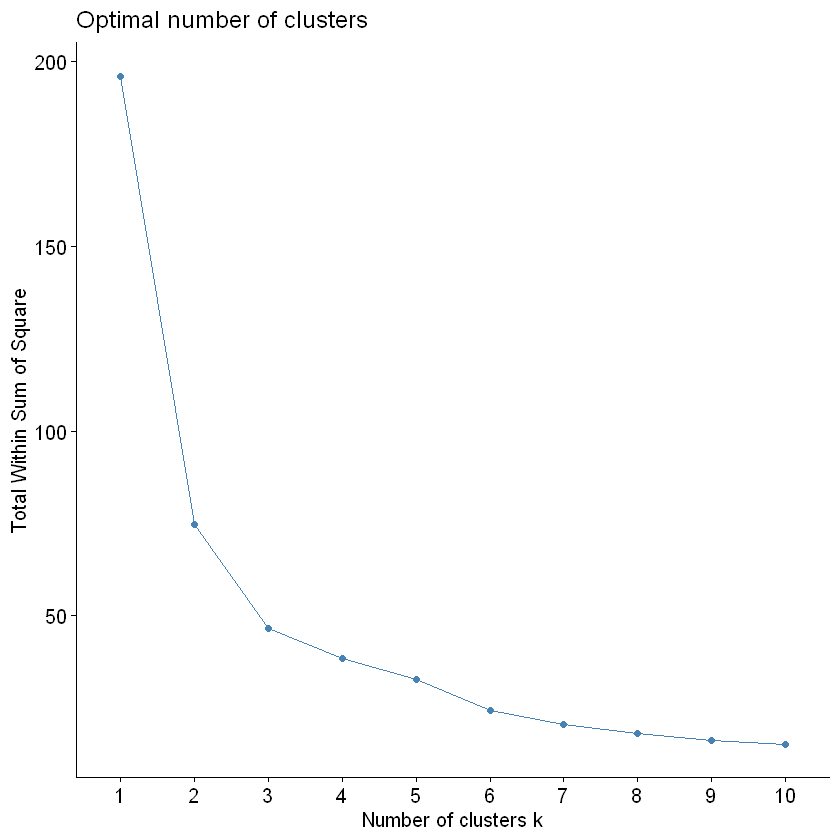

In [9]:
# Select and scale the relevant features and store as k_means_data
k_means_data <- degrees_clean %>%
    select(Starting.Median.Salary, Mid.Career.Median.Salary,Percentile.10, Percentile.90) 
k_means_data = scale(k_means_data)
# Run the fviz_nbclust function with our selected data and method "wss"
elbow_method <- fviz_nbclust(k_means_data, FUNcluster = kmeans, method = "wss")
# View the plot
elbow_method

### The Silhouette Method

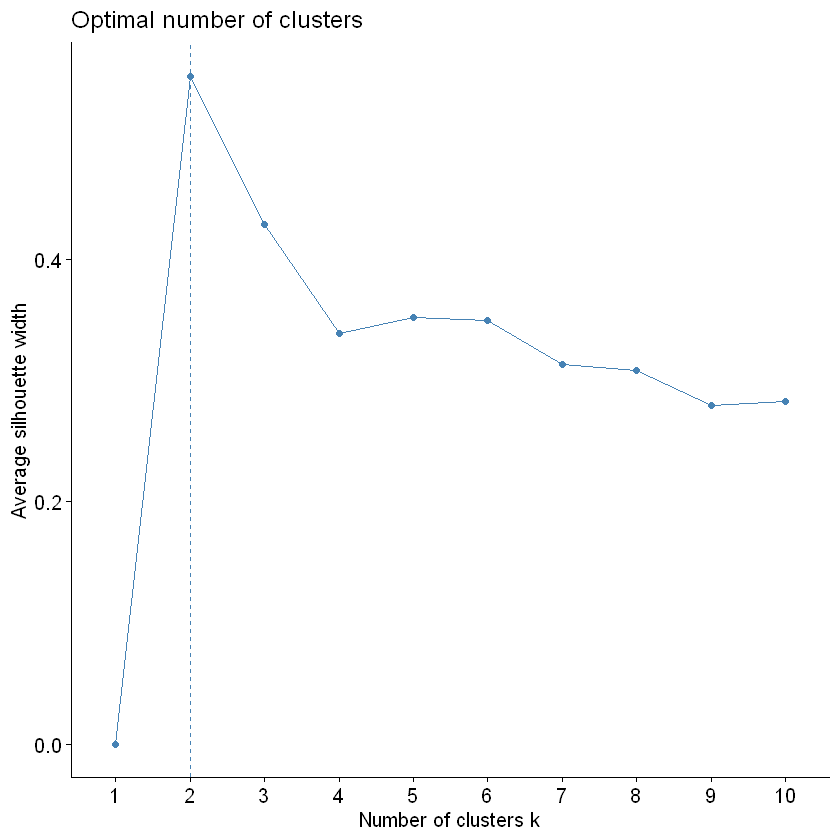

In [10]:
# Run the fviz_nbclust function with the method "silhouette" 
silhouette_method <- fviz_nbclust(k_means_data, FUNcluster = kmeans, method = "silhouette")
# View the plot
silhouette_method

### The Gap Statistic Method

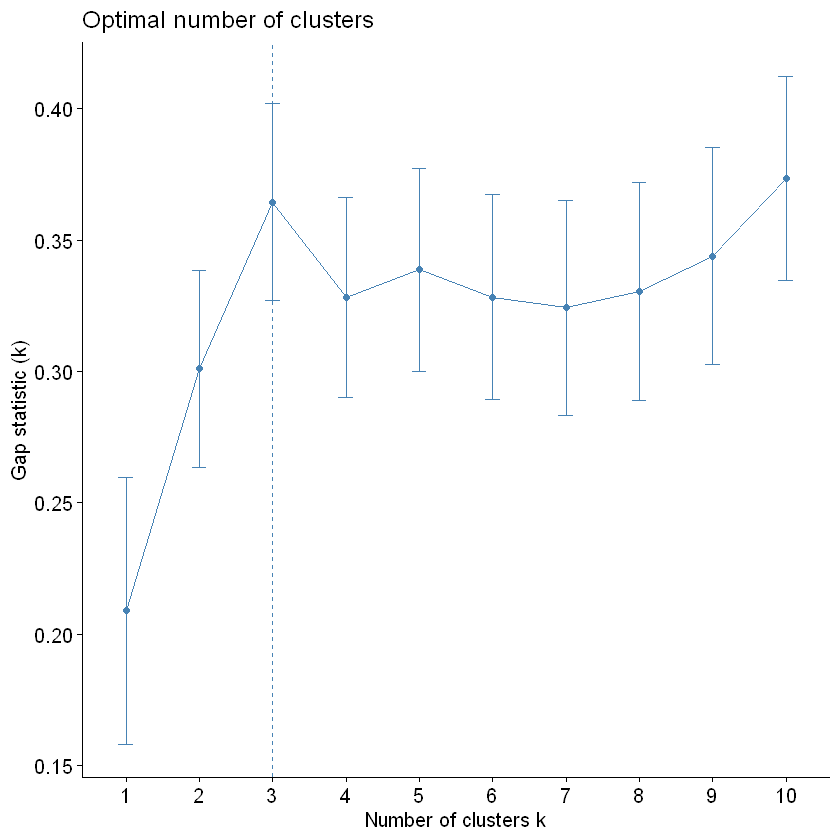

In [13]:
# Use the clusGap function to apply the Gap Statistic Method
gap_stat <- clusGap(k_means_data, FUN = kmeans, nstart = 25, K.max = 10, B = 50)
# Use the fviz_gap_stat function to vizualize the results
gap_stat_method <- fviz_gap_stat(gap_stat)
# View the plot
gap_stat_method

### K-Means Clustering

In [14]:
# Set k equal to the optimal number of clusters
num_clusters <- 3
# Run the k-means algorithm 
k_means <- kmeans(k_means_data, centers = num_clusters, iter.ma = 15, nstart = 25)
# Label the clusters of degrees_clean
degrees_labeled <- degrees_clean %>%
    mutate(clusters = k_means$cluster)

## Visualization the Clusters

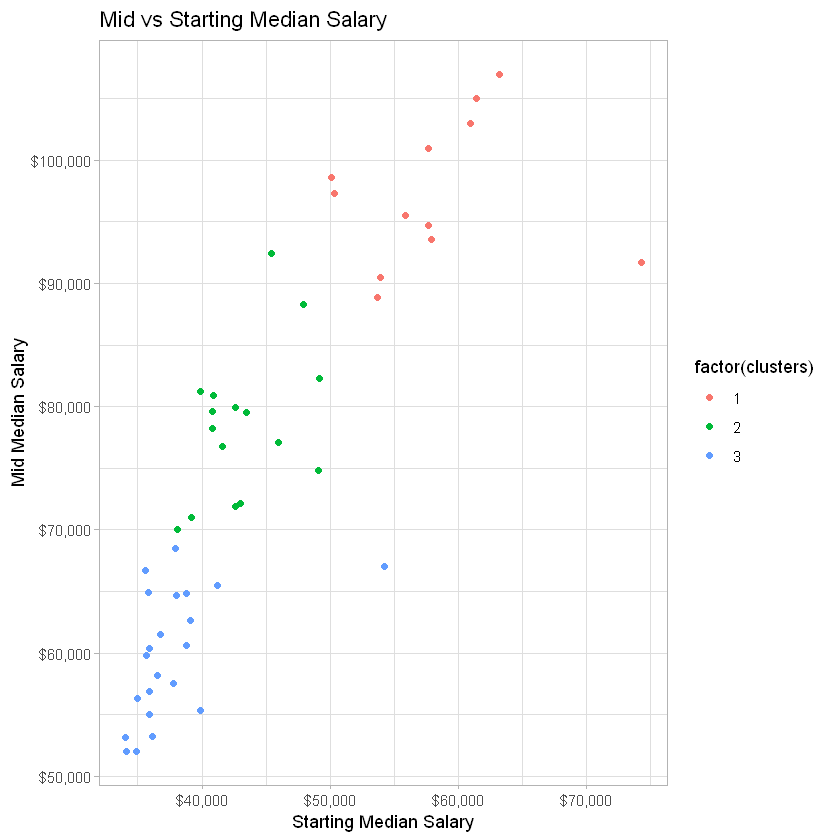

In [17]:
# Graph the clusters by Starting and Mid Career Median Salaries
career_growth <- ggplot(degrees_labeled, aes(x=Starting.Median.Salary,y=Mid.Career.Median.Salary,
                                             color=factor(clusters))) + 
geom_point() +
xlab("Starting Median Salary") + ylab("Mid Median Salary") +
ggtitle("Mid vs Starting Median Salary") + 
scale_x_continuous(labels = scales::dollar) + scale_y_continuous(labels = scales::dollar) +
theme_light()
# View the plot
career_growth

## Understanding the Clusters

In [18]:
# Use the gather function to reshape degrees and 
# use mutate() to reorder the new percentile column
degrees_perc <- degrees_labeled %>%
    select(College.Major, Percentile.10, Percentile.25, Mid.Career.Median.Salary, 
           Percentile.75, Percentile.90, clusters) %>%
    gather(key=percentile, value=salary, -c(College.Major, clusters)) %>%
    mutate(percentile = factor(percentile, 
                               levels=c('Percentile.10', 'Percentile.25',
                                        'Mid.Career.Median.Salary','Percentile.75', 
                                        'Percentile.90')))

### Liberal Arts Cluster 
Music is the riskiest major with the lowest 10th percentile salary, but Drama wins the highest growth potential in the 90th percentile for this cluster. Nursing is the outlier culprit of cluster number 1, with a higher safety net in the lowest percentile to the median. Otherwise, this cluster does represent the majors with limited growth opportunity.

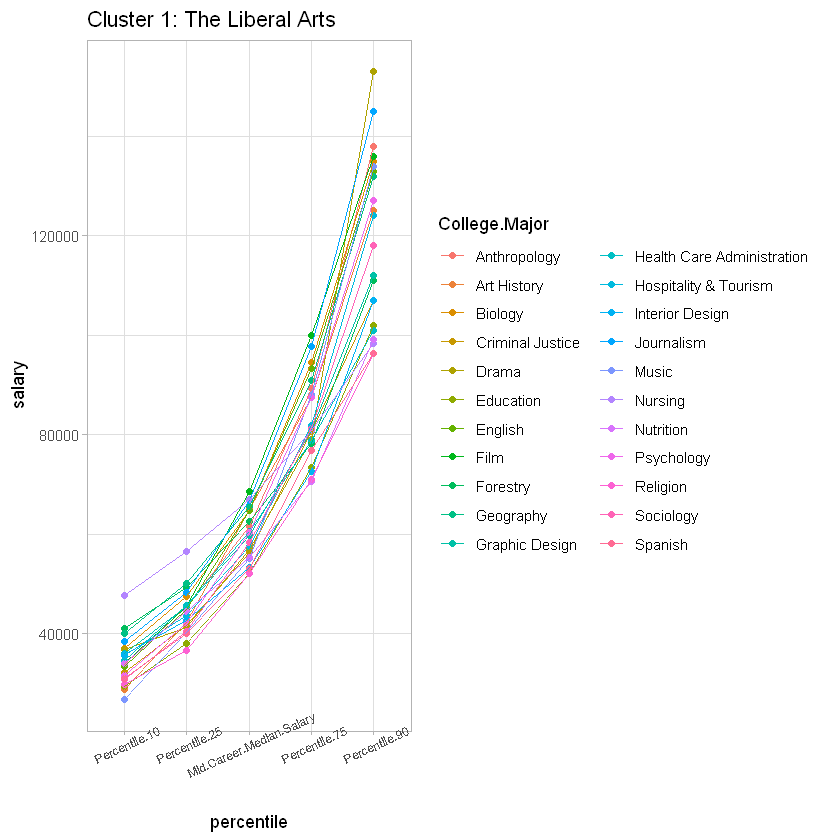

In [27]:
# Graph the majors of Cluster 1 by percentile
cluster_1 <- degrees_perc %>% filter(clusters == 3) %>% 
    ggplot(aes(x=percentile, y=salary, group=College.Major, color=College.Major)) + 
    geom_point() +
    geom_line() +
    ggtitle("Cluster 1: The Liberal Arts") +
    theme_light() +
    theme(axis.text.x = element_text(size=7, angle=25)) 
# View the plot
cluster_1

### Goldilocks Cluster
Accountants are known for having stable job security, but once you're in the big leagues Marketing or Philosophy can ultimately result in higher salaries. The majors of this cluster are fairly middle of the road in the dataset, starting off not too low and not too high in the lowest percentile. However, this cluster also represents the majors with the greatest differential between the lowest and highest percentiles.

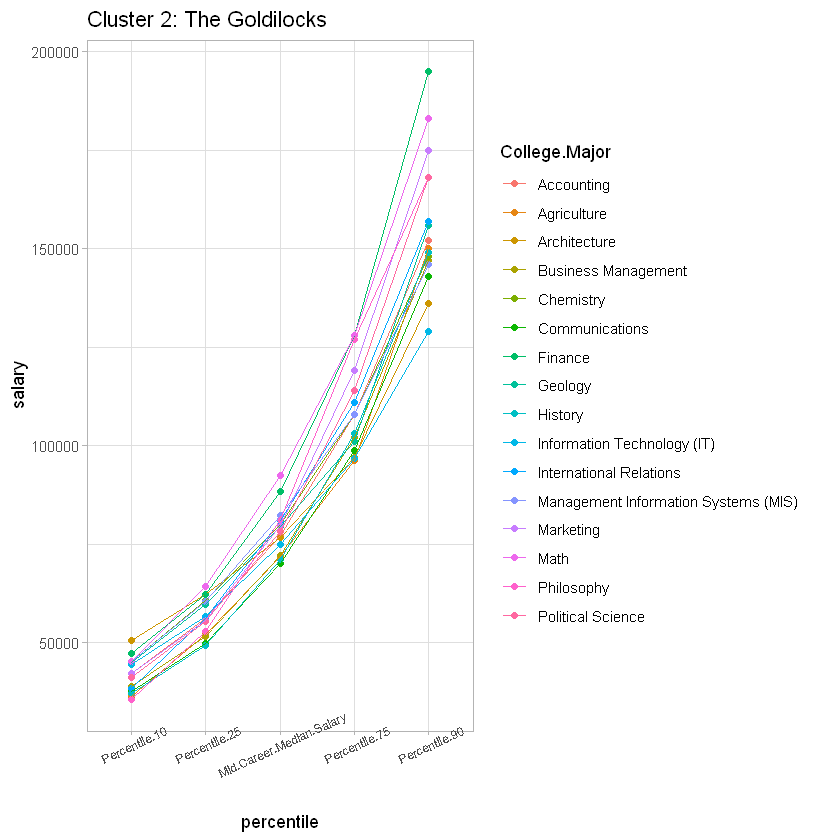

In [28]:
# Modify the previous plot to display Cluster 2
cluster_2 <- degrees_perc %>% filter(clusters == 2) %>% 
    ggplot(aes(x=percentile, y=salary, group=College.Major, color=College.Major)) + 
    geom_point() +
    geom_line() +
    ggtitle("Cluster 2: The Goldilocks") +
    theme_light() +
    theme(axis.text.x = element_text(size=7, angle=25))
# View the plot
cluster_2

### Over Achiever Cluster 
If you want financial security, these are the majors to choose from. Besides one previously observed outlier now identifiable as Physician Assistant lagging in the highest percentiles, these heavy hitters and solid engineers represent the highest growth potential in the 90th percentile, as well as the best security in the 10th percentile rankings.


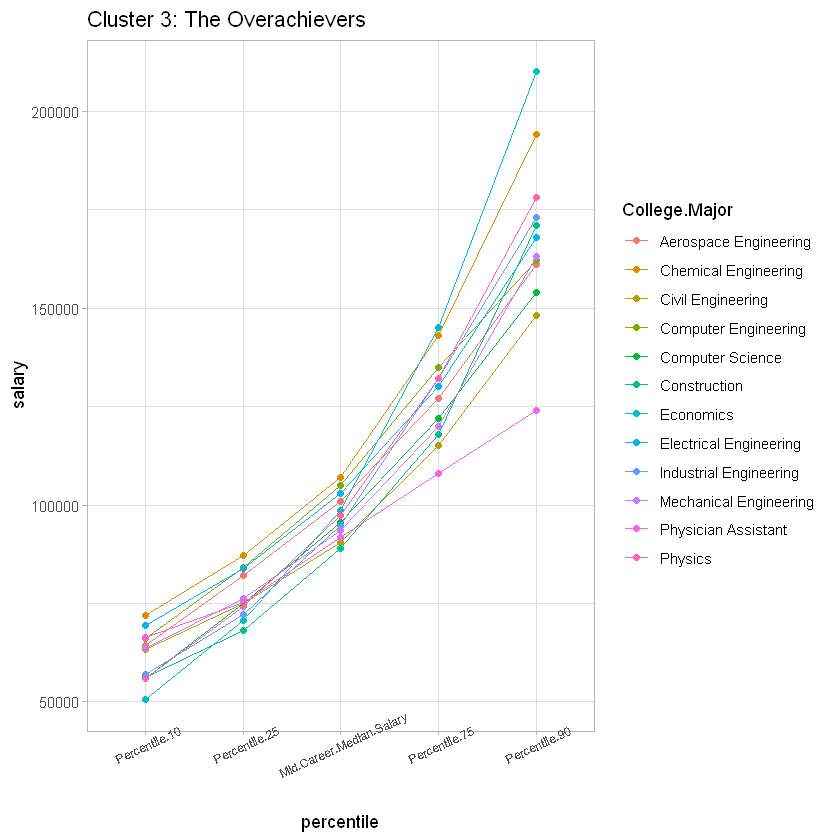

In [29]:
# Modify the previous plot to display Cluster 3
cluster_3 <- degrees_perc %>% filter(clusters == 1) %>% 
    ggplot(aes(x=percentile, y=salary, group=College.Major, color=College.Major)) + 
    geom_point() +
    geom_line() +
    ggtitle("Cluster 3: The Overachievers") +
    theme_light() +
    theme(axis.text.x = element_text(size=7, angle=25))
# View the plot
cluster_3